## 目标检测
* 训练和测试数据的图片都是用把单个目标粘在背景上得来的
* 要求用卷积神经网络检测粘在背景上的目标
* 提交结果存储为xml文件，每个测试图片对应一个xml文件，存储目标方框坐标和[0, 1]之间的置信度，每张图片可以有多个置信度不同的目标框
* 提交结果的格式如example.xml所示，对应图片example.jpg
* 训练数据和测试数据分别是trianval和text

训练图片和真值方框如下所示：

In [1]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import random
import keras.backend as K
import keras.losses
from keras.models import Model,load_model
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,Flatten,MaxPooling2D,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
#%matplotlib inline

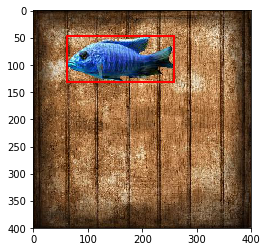

In [2]:
img = Image.open('trainval/img/Aquatic_theater_17_58.jpg')
img = np.array(img)
ann = ET.parse('trainval/box/Aquatic_theater_17_58.xml')
box = [int(ann.find(tag).text)-1
           for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle(
    (box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

示例结果格式如下所示：

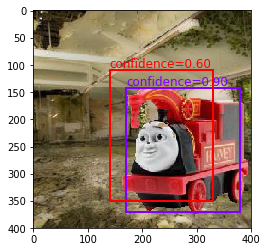

In [3]:
from matplotlib.pyplot import cm
img = Image.open('example.jpg')
img = np.array(img)
# 示例结果，两个方框，置信度分别是0.9和0.6
boxes = [[170, 142, 380, 370], [140, 110, 330, 350]]
confs = [0.9, 0.6]
fig, ax = plt.subplots(1)
ax.imshow(img)
color=iter(cm.rainbow(np.linspace(0, 1, len(boxes))))
for box, conf in zip(boxes, confs):
    c=next(color)
    rect = patches.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=c, facecolor='none')
    ax.add_patch(rect)
    ax.text(x=box[0], y=box[1]-5, s='confidence=%.2f'%conf, color=c, fontsize=12)
    
# 保存示例结果在example.xml里
result = ET.Element("prediction")
for box, conf in zip(boxes, confs):
    ann_bbox = ET.SubElement(result, "bndbox")
    ET.SubElement(ann_bbox, "xmin").text = str(box[0])
    ET.SubElement(ann_bbox, "ymin").text = str(box[1])
    ET.SubElement(ann_bbox, "xmax").text = str(box[2])
    ET.SubElement(ann_bbox, "ymax").text = str(box[3])
    ET.SubElement(ann_bbox, "conf").text = '%.4f'%conf
tree = ET.ElementTree(result)
tree.write('example.xml')

In [ ]:
imsize = 224

img_dir = 'trainval/img/'
imgs = os.listdir(img_dir)
num_total = len(imgs)
X = np.zeros((num_total,imsize,imsize,3))
LW = np.zeros((num_total,2))
Y = np.zeros((num_total,4))


In [ ]:
#这里是对img和box先做一个预处理
for it in range(num_total):
    img = Image.open('trainval/img/'+imgs[it])
    l,w,_ = np.array(img).shape
    LW[it] = np.array([l,w])
    img = img.resize((imsize,imsize))
    img = np.array(img)
    X[it] = img/255
    img_name = imgs[it][:-4]
    ann_name = img_name+'.xml'
    ann = ET.parse('trainval/box/'+ann_name)
    box = [int(ann.find(tag).text)-1
               for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
    xmin,ymin,xmax,ymax = box
    
    xmin_norm,xmax_norm = [xmin/w,xmax/w]
    ymin_norm,ymax_norm = [ymin/l,ymax/l]
    
    x_c = (xmin_norm+xmax_norm)/2 * imsize
    y_c = (ymin_norm+ymax_norm)/2 * imsize
    
    bbox_w = (xmax_norm - xmin_norm)* imsize
    bbox_l = (ymax_norm - ymin_norm)* imsize
    Y[it] = [x_c, y_c, bbox_w, bbox_l]
    
np.save("X.npy", X)
np.save("Y.npy", Y)

In [ ]:
X = np.load('X.npy')
Y = np.load('Y.npy')
random.seed(10)
#这里是为了保证X,Y的顺序保持一致
permutation = np.random.permutation(Y.shape[0])
X = X[permutation, :]
Y = Y[permutation]

X_train = X
Y_train = Y

In [ ]:
HUBER_DELTA = 0.5
def smoothL1(y_true, y_pred):
    x  = K.abs(y_true - y_pred)
    x  = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return  K.sum(x)

keras.losses.smoothL1 = smoothL1


In [ ]:
def Treatment(nb_classes=4, img_rows=imsize, img_cols=imsize, RGB=True):
    color = 3 if RGB else 1
    base_model = VGG19(weights='imagenet', include_top=True, pooling=None, input_shape=(img_rows, img_cols, color))
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.get_layer('fc2').output
    x = Dropout(0.5)(x)
    predictions = Dense(nb_classes, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # 这里与第二题不同在于选择了adam优化，看了一些资料可能adam比SGD要好一些，这里试一下不同的效果
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss=smoothL1, optimizer=adam)
    return model

def scheduler(epoch):
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(scheduler)
model = Treatment()
model.fit(X_train, Y_train, batch_size=16, epochs=25,callbacks=[lr_decay])

model.save('model')

In [1]:
from keras.models import Model,load_model
import numpy as np
X = np.load('X.npy')
Y = np.load('Y.npy')
# 这里是为了测一下训练集自身的准确率，用1/4的样本试一下
X_val = X[:500]
Y_val = Y[:500]
model = load_model('model')

#定义交并比
def iou(bbox,gt):
    iou = 0
    x,y,w,l = bbox
    x_gt,y_gt,w_gt,l_gt = gt
    x1,y1,x2,y2 = [x-w/2,y-l/2,x+w/2,y+l/2]
    x1_gt,y1_gt,x2_gt,y2_gt = [x_gt-w_gt/2,y_gt-l_gt/2,x_gt+w_gt/2,y_gt+l_gt/2]
    xi1 = max(x1,x1_gt)
    xi2 = min(x2,x2_gt)
    yi1 = max(y1,y1_gt)
    yi2 = min(y2,y2_gt)
    area_i = max(0,(xi2-xi1))*max(0,(yi2-yi1))
    area1 = w*l
    area2 = w_gt*l_gt
    area_u = area1+area2-area_i
    iou = area_i/area_u
    return iou

threshold = 0.5 #这里设定阈值为0.5
count = 0
num_val = 200
for i in range(num_val):
    bbox = model.predict(X_val[i:i+1])
    bbox = bbox.squeeze()
    GT = Y_val[i]
    tmp = iou(bbox,GT)
    if tmp>threshold:
        count=count+1
print("准确度为",count/num_val)


ImportError: No module named 'keras'

In [ ]:
img_dir = 'test/img/'
imgs = os.listdir(img_dir)
X_test = np.zeros((len(imgs),imsize,imsize,3))
LW_test = np.zeros((len(imgs),2))

for it in range(len(imgs)):
    img = Image.open('test/img/'+imgs[it])
    l,w,_ = np.array(img).shape
    LW_test[it] = np.array([l,w])
    img = img.resize((imsize,imsize))
    img = np.array(img)
    X_test[it] = img/255
    
np.save("X_test.npy",X_test)


In [ ]:
X_test = np.load('X_test.npy')

for it in range(len(imgs)):
    bbox = model.predict(X_test[it:it+1])
    bbox = bbox.squeeze()
    x,y,w,l = bbox
    x_min,y_min,x_max,y_max = [x-w/2,y-l/2,x+w/2,y+l/2]
    x_min = x_min/imsize * LW_test[it,1]
    x_max = x_max/imsize * LW_test[it,1]
    y_min = y_min/imsize * LW_test[it,0]
    y_max = y_max/imsize * LW_test[it,0]
    img_name = imgs[it][:-4]
    box = [x_min,y_min,x_max,y_max]
    conf = 1
    result = ET.Element("prediction")
    ann_box = ET.SubElement(result,"bndbox")
    ET.SubElement(ann_box, "xmin").text = str(int(box[0]))
    ET.SubElement(ann_box, "ymin").text = str(int(box[1]))
    ET.SubElement(ann_box, "xmax").text = str(int(box[2]))
    ET.SubElement(ann_box, "ymax").text = str(int(box[3]))
    ET.SubElement(ann_box, "conf").text = '%.4f'%conf
    tree = ET.ElementTree(result)
    tree.write('test/box/'+str(img_name)+'.xml')


In [ ]:
#展示一下最后结果
img = Image.open('test/img/113300_103.jpg')
img = np.array(img)
ann = ET.parse('test/box/113300_103.xml')
ann = ann.find('bndbox')
box = [int(ann.find(tag).text)-1
           for tag in ['xmin', 'ymin', 'xmax', 'ymax',]]
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle(
    (box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
